In [8]:
import h5py
import numpy as  np
from pathlib import Path
import math
from source.preprocessHighFPS import _chunk_to_fft
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["image.interpolation"] = 'none'

In [2]:
BASE_DIR = Path("D:/Studia/sium/semestr3/radar-project")  # change to your project dir
RADAR_DIR = BASE_DIR / "data/2023_03_21/chodzonko"  # day dir
GROUP_NAME = '2023_03_21' # nazwa grupy (np. dzień pomiaru), de facto to tylko kolejny wymiar
H5_FILENAME = 'alive_or_dead'

loaded_file = h5py.File('../data/'+ H5_FILENAME + '.h5','r')
frames = loaded_file[GROUP_NAME]['randomowe_chodzonko_1os_bartek']
frames = frames[:,0,0,:]

In [3]:
from source import helper

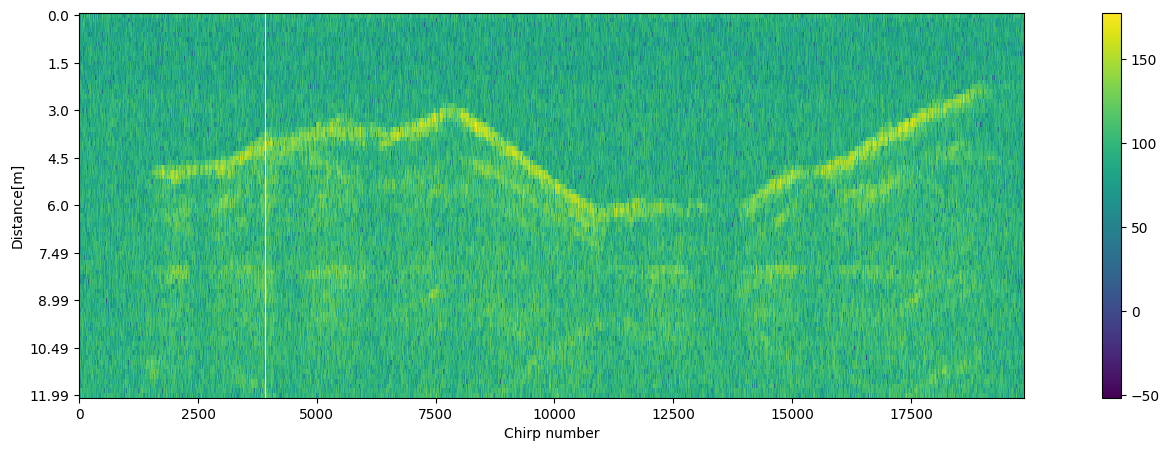

In [9]:
diff = helper.diff_frames(frames,  1)
distance_spect,y =  helper.gen_spectogram(diff)
distance_spect_db  = helper.to_dB(distance_spect)
helper.print_spectogram(distance_spect_db,y, 10,  12,100)

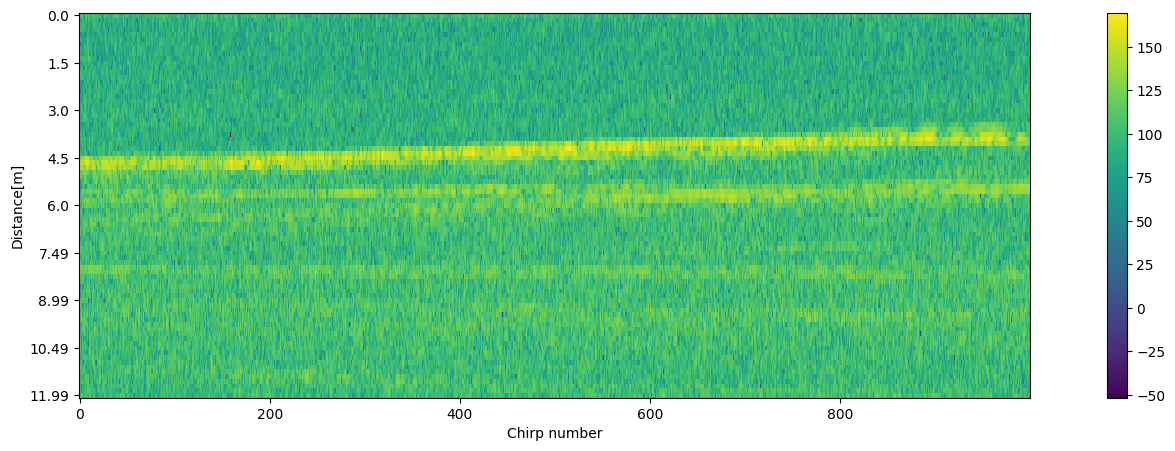

In [10]:
window = helper.get_window(diff,16000,1000)

distance_spect_window, y2 = helper.gen_spectogram(window)
distance_spect_window_db  = helper.to_dB(distance_spect_window)
helper.print_spectogram(distance_spect_window_db,y2, 10, 12,5)

In [11]:
window.shape

(1000, 512)

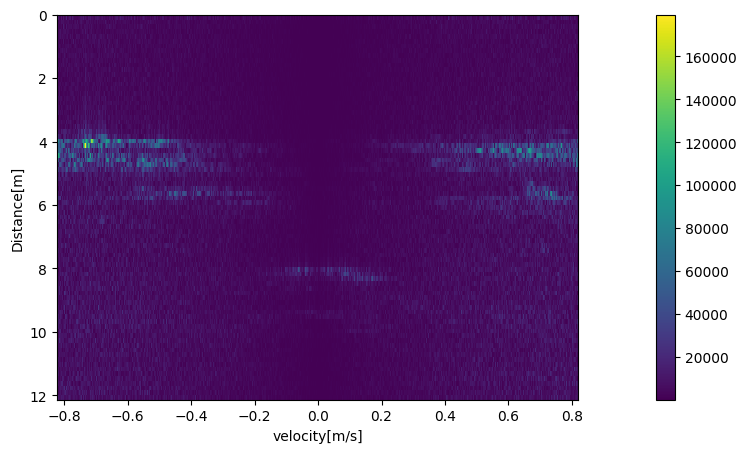

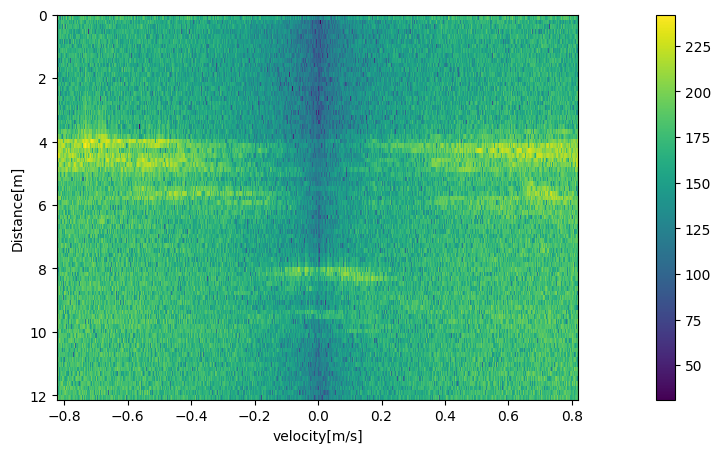

In [12]:
velocity_spect,y,x =  helper.gen_velocity_spectogram(window)
helper.print_vel_spectogram(velocity_spect,y,x,depth_limit=12, aspect=1/10)
velocity_spect_db = helper.to_dB(velocity_spect)
helper.print_vel_spectogram(velocity_spect_db,y,x,depth_limit=12, aspect=1/10)

co 10 klatke

In [16]:
frames = loaded_file[GROUP_NAME]['randomowe_chodzonko_1os_bartek']
frames = frames[::10,0,0,:]

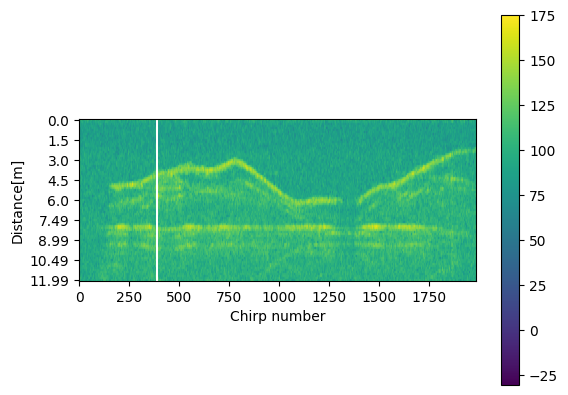

In [17]:
diff = helper.diff_frames(frames,  1)
distance_spect,y =  helper.gen_spectogram(diff)
distance_spect_db  = helper.to_dB(distance_spect)
helper.print_spectogram(distance_spect_db,y, 10,  12,10)

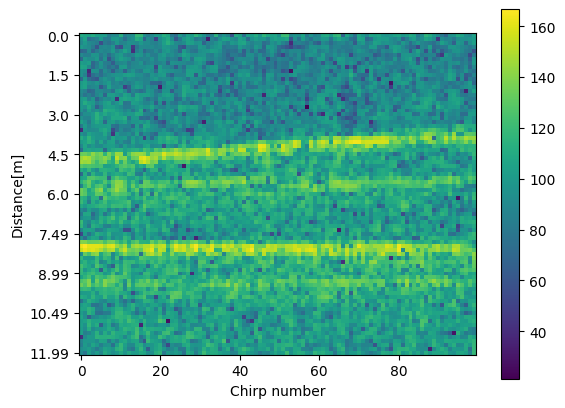

In [18]:
window = helper.get_window(diff,1600,100)

distance_spect_window, y2 = helper.gen_spectogram(window)
distance_spect_window_db  = helper.to_dB(distance_spect_window)
helper.print_spectogram(distance_spect_window_db,y2, 10, 12,1)

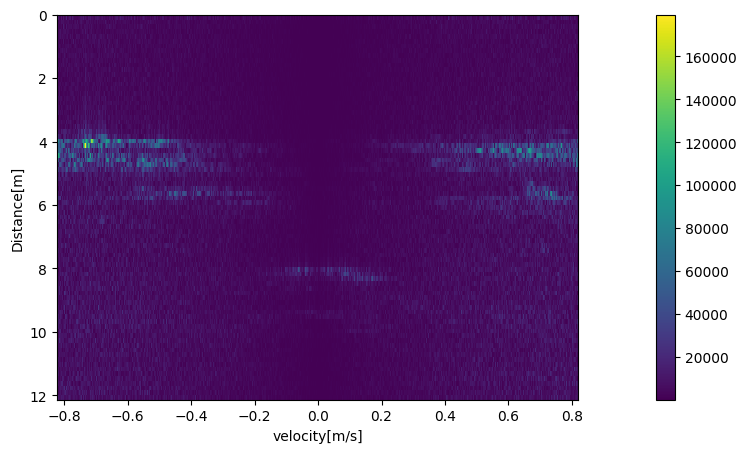

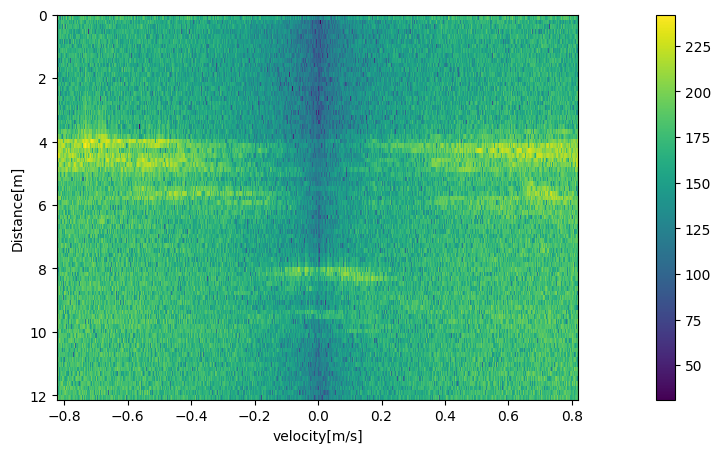

In [18]:
velocity_spect,y,x =  helper.gen_velocity_spectogram(window)
velocity_spect_db = helper.to_dB(velocity_spect)
helper.print_vel_spectogram(velocity_spect,y,x,depth_limit=12, aspect=1/10)
helper.print_vel_spectogram(velocity_spect_db,y,x,depth_limit=12, aspect=1/10)

In [34]:
def gen_velocity_spectogram(frames: np.ndarray, n: int = 512, t: int = 2924, f_slope: float = 5.711) -> (np.ndarray, np.array):
    """
    frames: np.array containing all the frames to transform
    n: number of bins
    t: sampling frequency
    f_slope: Frequency slope
    """
    scale = 1 / ((29.9792458 / f_slope) / 100)  # 29... is from speed of light
    t = 1 / t
    y = np.fft.fftfreq(n, d=t)[:n // 2]
    y = y / scale
    y /= 2
    y = np.round(y,2)

    first_fft = np.fft.fft(frames.imag, axis=1)
    first_fft = first_fft[:,:81]

    second_fft = np.fft.fft(first_fft.imag, axis=0)
    second_fft = np.fft.fftshift(second_fft, axes=0)
    second_fft = second_fft.imag
    c = 3e8 # Speed of light (m/s)

    start_freq = 77 # Starting frequency of the chirp (GHz)
    idle_time = 1000 # Time before starting next chirp (us)
    ramp_end_time = 182.52 # Time after sending each chirp (us)

    velocity_res = c / (2 * start_freq * 1e9 * (idle_time + ramp_end_time) * 1e-6 * frames.shape[1])
    # print(f'Velocity Resolution: {velocity_res} [meters/second]')

    # Apply the velocity resolution factor to the doppler indicies
    velocities = np.arange(frames.shape[1]) - (frames.shape[1] // 2)
    velocities = velocities * velocity_res

    return np.abs(second_fft.T),y, velocities

In [35]:
velocity_spect,y,x =  gen_velocity_spectogram(window)
velocity_spect_db = helper.to_dB(velocity_spect)


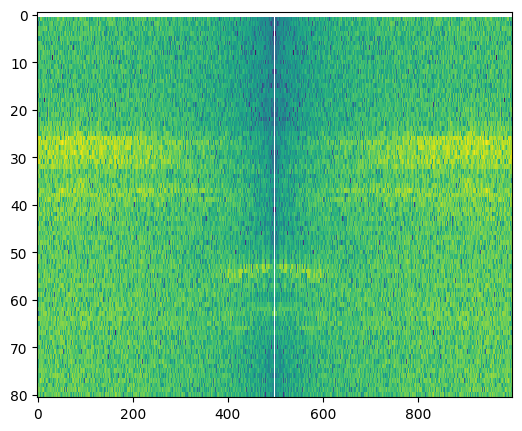

In [43]:
plt.imshow(velocity_spect_db[:,1:], aspect=10)

In [13]:
loaded_file.close()